In [1]:
import os
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys
sys.path.append('../scripts/')
import utils
import plot
from vae_model import CVAE

## 1. Load in Data

In [22]:
energy_scores1 = []
energy_scores2 = []
for i in [0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00]:
    
    #Load the date from 2021
    train_series, train_attr, val_series, val_attr, test_series, test_attr = utils.get_data('2021')

    #Standardize the data
    train_series, val_series, _, scaler_data = utils.standardize_data(train_series, val_series, test_series)

    #perform one-hot encoding
    ONEHOTENCODE = ['is_weekend','season','PV']
    train_attr = utils.one_hot_encode_columns(train_attr, ONEHOTENCODE)
    val_attr = utils.one_hot_encode_columns(val_attr, ONEHOTENCODE)
    test_attr = utils.one_hot_encode_columns(test_attr, ONEHOTENCODE)

    # MinMax scale the attributes -> this keeps the scales, which might be important for some attributes!
    train_attr, val_attr, test_attr, scaler_attr = utils.minmax_scale_attributes(train_attr,val_attr,test_attr)

    index = int(len(train_series)*i)

    #Create dataloaders for pytorch
    train_dataset = TensorDataset(torch.tensor(train_series[:index], dtype=torch.float32), torch.tensor(train_attr[:index], dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(val_series, dtype=torch.float32), torch.tensor(val_attr, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=1028, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1028, shuffle=False)

    test_attr  = torch.tensor(test_attr, dtype=torch.float32)

    input_size = train_series.shape[1] 
    condition_size = train_attr.shape[1]
    latent_size = 40

    RUN = 8
    TITLE = 'LS_40_Dec_FCN'
    RUN_OUTPUT_DIR = 'runs_test' + '/' + 'run'+str(RUN) + '/' + TITLE

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cvae_FCN = CVAE(input_size, latent_size, condition_size, device,'FCN').to(device)
    cvae_FCN.train_model(train_loader, 
                     val_loader, 
                     epochs = 800, 
                     output_dir = RUN_OUTPUT_DIR,
                     device = device,
                     lr = 0.001,
                     patience=50)
    
    TITLE = 'LS_40_add_attr__CNN'
    RUN_OUTPUT_DIR = 'runs' + '/' + 'run'+str(RUN) + '/' + TITLE
    cvae_CNN = CVAE(input_size, latent_size, condition_size, device, 'CNN').to(device)
    cvae_CNN.train_model(train_loader, 
                     val_loader, 
                     epochs = 1000, 
                     output_dir = RUN_OUTPUT_DIR,
                     device = device,
                     lr = 0.001,
                     patience = 50)

    generated_fcn = []
    generated_cnn = []
    for i, (org_serie,attr) in tqdm(enumerate(zip(test_series.values,test_attr)),total=len(test_attr)):
        new_samples = cvae_FCN.generate_samples(1,attr,device)
        new_samples = scaler_data.inverse_transform(new_samples)
        generated_fcn.extend(new_samples)

        new_samples = cvae_CNN.generate_samples(1,attr,device)
        new_samples = scaler_data.inverse_transform(new_samples)
        generated_cnn.extend(new_samples)

    generated_fcn = np.array(generated_fcn)
    generated_cnn = np.array(generated_cnn)

    def calculate_metrics_model(model, test_series, test_attr, scaler_data):
        energy_score = []
        
        for i,(org_serie,attr) in tqdm(enumerate(zip(test_series.values,test_attr)),total=len(test_attr)):
            new_samples = model.generate_samples(250,attr,device)
            new_samples = scaler_data.inverse_transform(new_samples)
    
            energy_score.append(utils.calculate_energy_score([1/250]*250, new_samples, org_serie))

        print('Energy Score:', np.mean(energy_score))

        return np.mean(energy_score)
    energy_scores1.append(calculate_metrics_model(cvae_FCN,test_series,test_attr,scaler_data))
    energy_scores2.append(calculate_metrics_model(cvae_CNN,test_series,test_attr,scaler_data))

Epoch 10/800, Loss: 61.142581939697266, Validation Loss: 78.42520751953126
Epoch 20/800, Loss: 49.976051330566406, Validation Loss: 61.559774017333986
Epoch 30/800, Loss: 43.429447174072266, Validation Loss: 57.85273132324219
Epoch 40/800, Loss: 40.740787506103516, Validation Loss: 55.81478500366211
Epoch 50/800, Loss: 39.40646743774414, Validation Loss: 54.43110809326172
Epoch 60/800, Loss: 36.16505432128906, Validation Loss: 53.9782211303711
Epoch 70/800, Loss: 33.84844207763672, Validation Loss: 53.67595443725586
Epoch 80/800, Loss: 32.681846618652344, Validation Loss: 54.194304656982425
Epoch 90/800, Loss: 30.473791122436523, Validation Loss: 52.9320671081543
Epoch 100/800, Loss: 29.097768783569336, Validation Loss: 52.839151763916014
Epoch 110/800, Loss: 27.427640914916992, Validation Loss: 52.879076385498045
Epoch 120/800, Loss: 25.91156005859375, Validation Loss: 52.12535018920899
Epoch 130/800, Loss: 26.32300567626953, Validation Loss: 52.43671875
Epoch 140/800, Loss: 24.342746

100%|██████████| 4857/4857 [00:11<00:00, 436.78it/s]


Energy Score: 1.1038531576182218


100%|██████████| 4857/4857 [00:13<00:00, 355.07it/s]


Energy Score: 1.2442885911510302
Epoch 10/800, Loss: 50.798760732014976, Validation Loss: 54.32356262207031
Epoch 20/800, Loss: 44.54299290974935, Validation Loss: 48.76583480834961
Epoch 30/800, Loss: 43.89362589518229, Validation Loss: 46.48645782470703
Epoch 40/800, Loss: 40.16578165690104, Validation Loss: 44.26377563476562
Epoch 50/800, Loss: 38.77085622151693, Validation Loss: 42.40817565917969
Epoch 60/800, Loss: 36.602213541666664, Validation Loss: 41.38004760742187
Epoch 70/800, Loss: 36.7947629292806, Validation Loss: 40.405609130859375
Epoch 80/800, Loss: 33.381848653157554, Validation Loss: 39.27677764892578
Epoch 90/800, Loss: 32.791674296061196, Validation Loss: 38.7943473815918
Epoch 100/800, Loss: 31.421946207682293, Validation Loss: 37.96647186279297
Epoch 110/800, Loss: 31.235171635945637, Validation Loss: 37.38899536132813
Epoch 120/800, Loss: 31.11241912841797, Validation Loss: 37.05862045288086
Epoch 130/800, Loss: 29.775496164957683, Validation Loss: 36.4703155517

100%|██████████| 4857/4857 [00:30<00:00, 159.61it/s]


Energy Score: 0.9484840534850909


100%|██████████| 4857/4857 [00:34<00:00, 138.86it/s]


Energy Score: 1.0468295492830297
Epoch 10/800, Loss: 47.35656814575195, Validation Loss: 49.65600051879883
Epoch 20/800, Loss: 41.54889678955078, Validation Loss: 44.90909652709961
Epoch 30/800, Loss: 37.676412963867186, Validation Loss: 41.31067886352539
Epoch 40/800, Loss: 35.24059143066406, Validation Loss: 38.83734817504883
Epoch 50/800, Loss: 33.07743911743164, Validation Loss: 36.96737976074219
Epoch 60/800, Loss: 32.03115730285644, Validation Loss: 35.69176254272461
Epoch 70/800, Loss: 30.674504852294923, Validation Loss: 34.870862579345705
Epoch 80/800, Loss: 29.747458267211915, Validation Loss: 34.65327835083008
Epoch 90/800, Loss: 29.018040466308594, Validation Loss: 34.28259811401367
Epoch 100/800, Loss: 28.269816589355468, Validation Loss: 33.796593475341794
Epoch 110/800, Loss: 27.906664657592774, Validation Loss: 33.70485305786133
Epoch 120/800, Loss: 26.911459732055665, Validation Loss: 33.57448539733887
Epoch 130/800, Loss: 26.65935287475586, Validation Loss: 33.4963954

100%|██████████| 4857/4857 [00:31<00:00, 155.50it/s]


Energy Score: 0.9392290568761235


100%|██████████| 4857/4857 [00:37<00:00, 128.99it/s]


Energy Score: 0.9607394011980587
Epoch 10/800, Loss: 45.421954018729075, Validation Loss: 47.3790771484375
Epoch 20/800, Loss: 39.559984479631694, Validation Loss: 41.32929229736328
Epoch 30/800, Loss: 35.451690673828125, Validation Loss: 37.90068588256836
Epoch 40/800, Loss: 32.81752722603934, Validation Loss: 35.42533645629883
Epoch 50/800, Loss: 31.441645758492605, Validation Loss: 34.59813537597656
Epoch 60/800, Loss: 30.241397312709264, Validation Loss: 33.587470626831056
Epoch 70/800, Loss: 29.400748116629465, Validation Loss: 33.19976806640625
Epoch 80/800, Loss: 28.496886934552872, Validation Loss: 32.75503425598144
Epoch 90/800, Loss: 28.1254209790911, Validation Loss: 32.60504570007324
Epoch 100/800, Loss: 27.486491884504044, Validation Loss: 32.199568557739255
Epoch 110/800, Loss: 26.67365292140416, Validation Loss: 32.083612060546876
Epoch 120/800, Loss: 26.373507363455637, Validation Loss: 32.22663345336914
Epoch 130/800, Loss: 25.943488802228654, Validation Loss: 32.31666

100%|██████████| 4857/4857 [00:16<00:00, 291.62it/s]


Energy Score: 0.9302706621345626


100%|██████████| 4857/4857 [00:12<00:00, 396.74it/s]


Energy Score: 0.9647428619244233
Epoch 10/800, Loss: 43.55265129937066, Validation Loss: 45.421329498291016
Epoch 20/800, Loss: 37.15397516886393, Validation Loss: 39.420631408691406
Epoch 30/800, Loss: 33.5225830078125, Validation Loss: 35.313690185546875
Epoch 40/800, Loss: 31.609085930718315, Validation Loss: 33.780722045898436
Epoch 50/800, Loss: 30.37133174472385, Validation Loss: 32.9098819732666
Epoch 60/800, Loss: 29.325828976101345, Validation Loss: 32.23199043273926
Epoch 70/800, Loss: 28.594524171617294, Validation Loss: 31.754091262817383
Epoch 80/800, Loss: 27.89803187052409, Validation Loss: 31.7641902923584
Epoch 90/800, Loss: 27.184830135769314, Validation Loss: 31.455447006225587
Epoch 100/800, Loss: 26.68021117316352, Validation Loss: 31.339436721801757
Epoch 110/800, Loss: 26.427259657118057, Validation Loss: 31.210591125488282
Epoch 120/800, Loss: 25.96943367852105, Validation Loss: 31.035332870483398
Epoch 130/800, Loss: 25.442047331068252, Validation Loss: 31.3763

100%|██████████| 4857/4857 [00:09<00:00, 518.71it/s]


Energy Score: 0.9219021422118088


100%|██████████| 4857/4857 [00:11<00:00, 408.02it/s]


Energy Score: 0.9348056601057746
Epoch 10/800, Loss: 44.31899770100912, Validation Loss: 45.12132034301758
Epoch 20/800, Loss: 39.88367875417074, Validation Loss: 40.553550720214844
Epoch 30/800, Loss: 36.08919143676758, Validation Loss: 37.44235687255859
Epoch 40/800, Loss: 35.45655123392741, Validation Loss: 36.46275405883789
Epoch 50/800, Loss: 34.32739528020223, Validation Loss: 34.98019790649414
Epoch 60/800, Loss: 33.08572498957316, Validation Loss: 34.78042907714844
Epoch 70/800, Loss: 31.883988698323567, Validation Loss: 33.65951232910156
Epoch 80/800, Loss: 31.624728520711262, Validation Loss: 33.081377792358396
Epoch 90/800, Loss: 31.60846487681071, Validation Loss: 33.24580841064453
Epoch 100/800, Loss: 31.66667954126994, Validation Loss: 32.98007087707519
Epoch 110/800, Loss: 30.500565846761067, Validation Loss: 32.78130760192871
Epoch 120/800, Loss: 30.837273279825848, Validation Loss: 32.73696746826172
Epoch 130/800, Loss: 30.241671085357666, Validation Loss: 31.971005630

100%|██████████| 4857/4857 [00:09<00:00, 512.84it/s]


Energy Score: 0.9301422607023458


100%|██████████| 4857/4857 [00:11<00:00, 409.74it/s]


Energy Score: 0.9442652380011222
Epoch 10/800, Loss: 40.25383268083845, Validation Loss: 41.558232116699216
Epoch 20/800, Loss: 34.258466311863494, Validation Loss: 36.17347259521485
Epoch 30/800, Loss: 31.668078558785574, Validation Loss: 33.488729858398436
Epoch 40/800, Loss: 30.353807994297572, Validation Loss: 32.34417495727539
Epoch 50/800, Loss: 29.537402970450266, Validation Loss: 31.65128517150879
Epoch 60/800, Loss: 28.73350633893694, Validation Loss: 31.281841278076172
Epoch 70/800, Loss: 28.177566528320312, Validation Loss: 30.738882064819336
Epoch 80/800, Loss: 27.42513520377023, Validation Loss: 30.735177993774414
Epoch 90/800, Loss: 26.896537917000906, Validation Loss: 30.45200080871582
Epoch 100/800, Loss: 26.462082045418875, Validation Loss: 30.08181800842285
Epoch 110/800, Loss: 26.152720996311732, Validation Loss: 30.007932662963867
Epoch 120/800, Loss: 25.964453833443777, Validation Loss: 29.987516021728517
Epoch 130/800, Loss: 25.60189151763916, Validation Loss: 30.

100%|██████████| 4857/4857 [00:09<00:00, 511.33it/s]


Energy Score: 0.9234185168950871


100%|██████████| 4857/4857 [00:12<00:00, 400.22it/s]


Energy Score: 0.9357159260110991
Epoch 10/800, Loss: 38.35246968269348, Validation Loss: 40.51076202392578
Epoch 20/800, Loss: 32.877601861953735, Validation Loss: 34.548316192626956
Epoch 30/800, Loss: 30.73739516735077, Validation Loss: 32.879845428466794
Epoch 40/800, Loss: 29.46067523956299, Validation Loss: 31.42623100280762
Epoch 50/800, Loss: 28.591942071914673, Validation Loss: 30.89278678894043
Epoch 60/800, Loss: 27.777960300445557, Validation Loss: 30.599136352539062
Epoch 70/800, Loss: 27.207160592079163, Validation Loss: 30.189834976196288
Epoch 80/800, Loss: 26.656283855438232, Validation Loss: 30.166643142700195
Epoch 90/800, Loss: 26.42708384990692, Validation Loss: 29.79336814880371
Epoch 100/800, Loss: 26.013739824295044, Validation Loss: 29.79855308532715
Epoch 110/800, Loss: 25.4920574426651, Validation Loss: 29.647959899902343
Epoch 120/800, Loss: 25.168017268180847, Validation Loss: 29.666160583496094
Epoch 130/800, Loss: 24.905102729797363, Validation Loss: 29.80

100%|██████████| 4857/4857 [00:09<00:00, 492.82it/s]


Energy Score: 0.9183052407597199


100%|██████████| 4857/4857 [00:12<00:00, 388.52it/s]


Energy Score: 0.9309442870267637
Epoch 10/800, Loss: 37.30766847398546, Validation Loss: 38.583184814453126
Epoch 20/800, Loss: 32.186419592963325, Validation Loss: 33.700652313232425
Epoch 30/800, Loss: 30.251875771416557, Validation Loss: 31.903408813476563
Epoch 40/800, Loss: 29.05213673909505, Validation Loss: 31.192118072509764
Epoch 50/800, Loss: 28.165268686082626, Validation Loss: 30.51240653991699
Epoch 60/800, Loss: 27.46571339501275, Validation Loss: 29.915708923339842
Epoch 70/800, Loss: 26.83288076188829, Validation Loss: 29.58838310241699
Epoch 80/800, Loss: 26.408318201700848, Validation Loss: 29.381404876708984
Epoch 90/800, Loss: 26.00075255499946, Validation Loss: 29.28934555053711
Epoch 100/800, Loss: 25.63989649878608, Validation Loss: 29.296226501464844
Epoch 110/800, Loss: 25.330331908331978, Validation Loss: 29.131916809082032
Epoch 120/800, Loss: 25.209688504536945, Validation Loss: 29.449713134765624
Epoch 130/800, Loss: 24.86720021565755, Validation Loss: 29.3

100%|██████████| 4857/4857 [00:09<00:00, 498.96it/s]


Energy Score: 0.9186980439670915


100%|██████████| 4857/4857 [00:12<00:00, 390.68it/s]


Energy Score: 0.9239687402001581
Epoch 10/800, Loss: 37.00257949829101, Validation Loss: 38.875372314453124
Epoch 20/800, Loss: 31.5768762588501, Validation Loss: 33.0194652557373
Epoch 30/800, Loss: 29.965496063232422, Validation Loss: 31.738491439819335
Epoch 40/800, Loss: 28.732896041870116, Validation Loss: 30.470621871948243
Epoch 50/800, Loss: 27.975243949890135, Validation Loss: 30.19543037414551
Epoch 60/800, Loss: 27.272930812835693, Validation Loss: 29.4938045501709
Epoch 70/800, Loss: 26.752515029907226, Validation Loss: 29.324353790283205
Epoch 80/800, Loss: 26.244381427764893, Validation Loss: 29.193709564208984
Epoch 90/800, Loss: 25.864585208892823, Validation Loss: 28.86277656555176
Epoch 100/800, Loss: 25.595643615722658, Validation Loss: 28.953559112548827
Epoch 110/800, Loss: 25.277960968017577, Validation Loss: 28.86217346191406
Epoch 120/800, Loss: 24.89397554397583, Validation Loss: 28.860947799682616
Epoch 130/800, Loss: 24.78539276123047, Validation Loss: 28.717

100%|██████████| 4857/4857 [00:10<00:00, 481.54it/s]


Energy Score: 0.9203059382140352


100%|██████████| 4857/4857 [00:12<00:00, 376.74it/s]


Energy Score: 0.9288777997473467
Epoch 10/800, Loss: 37.89778568433679, Validation Loss: 38.626512908935545
Epoch 20/800, Loss: 32.37394672891368, Validation Loss: 34.20442123413086
Epoch 30/800, Loss: 31.015455411828082, Validation Loss: 32.2383228302002
Epoch 40/800, Loss: 30.131734516309656, Validation Loss: 31.262479400634767
Epoch 50/800, Loss: 29.22101161790931, Validation Loss: 30.857325744628906
Epoch 60/800, Loss: 28.585947451384172, Validation Loss: 30.129244995117187
Epoch 70/800, Loss: 27.954118894494098, Validation Loss: 29.8990421295166
Epoch 80/800, Loss: 27.65974757982337, Validation Loss: 29.503337860107422
Epoch 90/800, Loss: 27.401918411254883, Validation Loss: 29.51930961608887
Epoch 100/800, Loss: 26.886144720989726, Validation Loss: 28.993654632568358
Epoch 110/800, Loss: 26.919789024021316, Validation Loss: 29.173543548583986
Epoch 120/800, Loss: 26.720568200816277, Validation Loss: 29.406090545654298
Epoch 130/800, Loss: 26.09202890810759, Validation Loss: 29.09

100%|██████████| 4857/4857 [00:10<00:00, 483.90it/s]


Energy Score: 0.9173137138949881


100%|██████████| 4857/4857 [00:12<00:00, 383.37it/s]

Energy Score: 0.9253705326024184


In [16]:
len(energy_scores1)

9

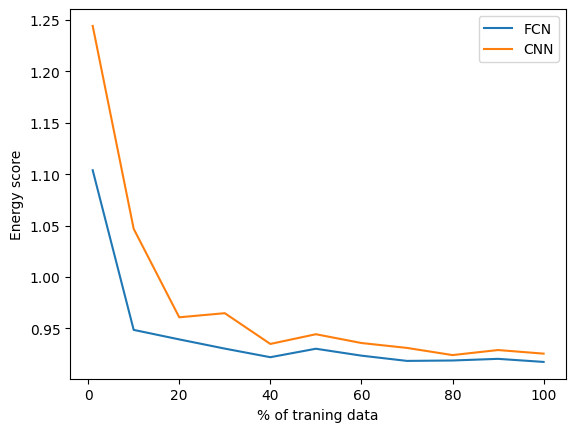

In [29]:
x = np.array([0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00])*100
plt.plot(x,energy_scores1,label='FCN')
plt.plot(x,energy_scores2,label='CNN')
plt.xlabel('% of traning data')
plt.ylabel('Energy score')
plt.legend()
plt.show()

In [23]:
#Load the best models
cvae_FCN.load_state_dict(torch.load(r'C:\Thesis\vae\runs\run7\LS_40_add_attr_FCN\best_model.pt'))
cvae_FCN.eval()
cvae_CNN.load_state_dict(torch.load(r'C:\Thesis\vae\runs\run7\LS_40_add_attr__CNN\best_model.pt'))
cvae_CNN.eval()

CVAE(
  (encoder): EncoderCNN(
    (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=6166, out_features=256, bias=True)
    (fc_mu): Linear(in_features=256, out_features=40, bias=True)
    (fc_var): Linear(in_features=256, out_features=40, bias=True)
  )
  (decoder): DecoderCNN(
    (fc1): Linear(in_features=62, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=12288, bias=True)
    (deconv1): ConvTranspose1d(128,

In [24]:
generated_fcn = []
generated_cnn = []
for i, (org_serie,attr) in tqdm(enumerate(zip(test_series.values,test_attr)),total=len(test_attr)):
        new_samples = cvae_FCN.generate_samples(1,attr,device)
        new_samples = scaler_data.inverse_transform(new_samples)
        generated_fcn.extend(new_samples)

        new_samples = cvae_CNN.generate_samples(1,attr,device)
        new_samples = scaler_data.inverse_transform(new_samples)
        generated_cnn.extend(new_samples)

generated_fcn = np.array(generated_fcn)
generated_cnn = np.array(generated_cnn)

100%|██████████| 4857/4857 [00:06<00:00, 797.56it/s]


## 4. Model evaluation

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_metrics_model(model, test_series, test_attr, scaler_data):
    energy_score = []
    mse = []
    mae = []
    
    for i,(org_serie,attr) in tqdm(enumerate(zip(test_series.values,test_attr)),total=len(test_attr)):
        new_samples = model.generate_samples(250,attr,device)
        new_samples = scaler_data.inverse_transform(new_samples)

        energy_score.append(utils.calculate_energy_score([1/250]*250, new_samples, org_serie))
        mse.append(mean_squared_error(new_samples,np.array([org_serie]*250)))
        mae.append(mean_absolute_error(new_samples,np.array([org_serie]*250)))

    print('Energy Score:', np.mean(energy_score))
    print('mse', np.mean(mse))
    print('mae', np.mean(mae))

### 4.1 Energy Score

For each attribute generate 250 samples & compare with the ground truth.

In [43]:
print('FCN')
calculate_metrics_model(cvae_FCN,test_series,test_attr,scaler_data)

FCN


100%|██████████| 4857/4857 [00:12<00:00, 386.16it/s]

Energy Score: 0.9174298458733671
mse 0.031679739947001746
mae 0.09827193631746875


In [27]:
print('CNN')
calculate_metrics_model(cvae_CNN,test_series,test_attr,scaler_data)

CNN


100%|██████████| 4857/4857 [00:13<00:00, 348.28it/s]

Energy Score: 0.9281587040539253
mse 0.03257160145827778
mae 0.10255730240046133


Calculate for random days & random

In [30]:
es_random = []
es_similar_days = []
mse_similar_days = []
mse_random = []
mae_similar_days = []
mae_random = []
for (org_serie,attr) in tqdm(zip(test_series.values,test_attr),total=len(test_attr)):
    samples_random = utils.get_random_days(test_series.values,250)
    samples_similar = utils.get_similar_days(test_series.values,test_attr,attr,250)
    es_random.append(utils.calculate_energy_score([1/250]*250, samples_random, org_serie))
    es_similar_days.append(utils.calculate_energy_score([1/250]*250, samples_similar, org_serie))
    mse_similar_days.append(mean_squared_error(samples_similar,np.array([org_serie]*250)))
    mse_random.append(mean_absolute_error(samples_random,np.array([org_serie]*250)))
    mae_similar_days.append(mean_squared_error(samples_similar,np.array([org_serie]*250)))
    mae_random.append(mean_absolute_error(samples_random,np.array([org_serie]*250)))

print('SIMILAR-es:' ,np.mean(es_similar_days))
print('RANDOM-es:' ,np.mean(es_random))
print('SIMILAR-mse:' ,np.mean(mse_similar_days))
print('RANDOM-mse:' ,np.mean(mse_random))
print('SIMILAR-mae:' ,np.mean(mae_similar_days))
print('RANDOM-mae:' ,np.mean(mae_random))

100%|██████████| 4857/4857 [00:12<00:00, 394.56it/s]

SIMILAR-es: 1.0893003571199036
RANDOM-es: 1.3451588205479463
SIMILAR-mse: 0.06385754949686595
RANDOM-mse: 0.18872282547611696
SIMILAR-mae: 0.06385754949686595
RANDOM-mae: 0.18872282547611696


### 3.2 Visualization techniques

#### 3.2.1 Load Curves

In [32]:
def calculate_mean_loadcurve(data):
    load_curves = []
    for d in data:
        shift = np.abs(np.min(d)) + 1e-6
        ts_shifted = d + shift
        ts_sorted = np.sort(ts_shifted)
        # Compute the cumulative probability of occurrence for each data point
        cdf = np.cumsum(ts_sorted) / np.sum(ts_sorted)
        load_curves.append(ts_sorted)
    return np.mean(load_curves,axis=0)

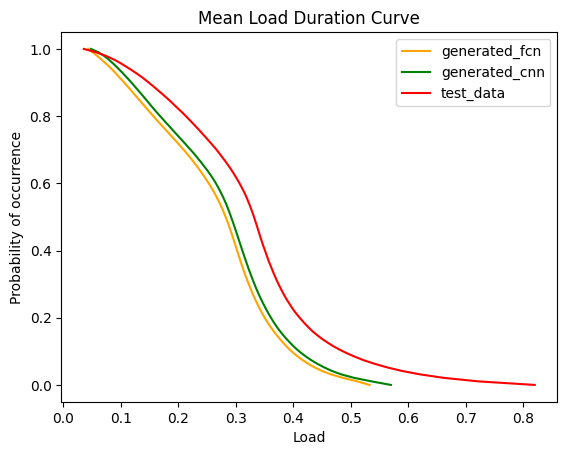

In [33]:
fig, ax = plt.subplots()

ax.plot(calculate_mean_loadcurve(generated_fcn),np.linspace(1, 0, len(calculate_mean_loadcurve(generated_fcn))), c='orange',label='generated_fcn')
ax.plot(calculate_mean_loadcurve(generated_cnn),np.linspace(1, 0, len(calculate_mean_loadcurve(generated_cnn))), c='green',label='generated_cnn')
ax.plot(calculate_mean_loadcurve(test_series.values),np.linspace(1, 0, len(calculate_mean_loadcurve(test_series.values))), c='r',label='test_data')

# Plot the load duration curve
ax.set_xlabel('Load')
ax.set_ylabel('Probability of occurrence')
ax.set_title('Mean Load Duration Curve')
ax.legend()
plt.show()

#kernel density estimation

#### 3.2.2 Quantile Plots

In [30]:
def create_quantile_plot(time_series,single_time_series=None):
    quantiles = np.arange(0.0,1.05,0.05)
    time_series_quantiles = np.quantile(time_series,quantiles,axis=0)
    timestamps = np.arange(time_series_quantiles.shape[1])
    cmap = plt.get_cmap('Blues', len(quantiles)//1.5)
    for i in range(len(quantiles)-1):
        color_idx = i if i < len(quantiles) // 2 else len(quantiles) - 2 - i
        plt.fill_between(timestamps, time_series_quantiles[i], time_series_quantiles[i + 1],
                     color=cmap(color_idx + 1), alpha=1)

    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title('Time Series Quantiles (0-100)')
    if single_time_series is not None:
        plt.plot(single_time_series,c='orange')
    plt.show()

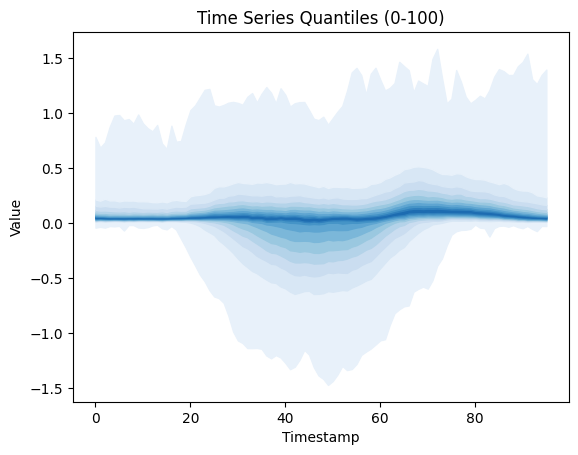

In [31]:
create_quantile_plot(generated_fcn)

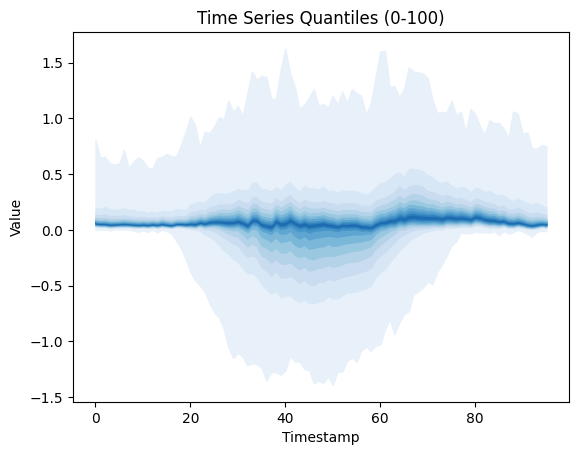

In [32]:
create_quantile_plot(generated_cnn)

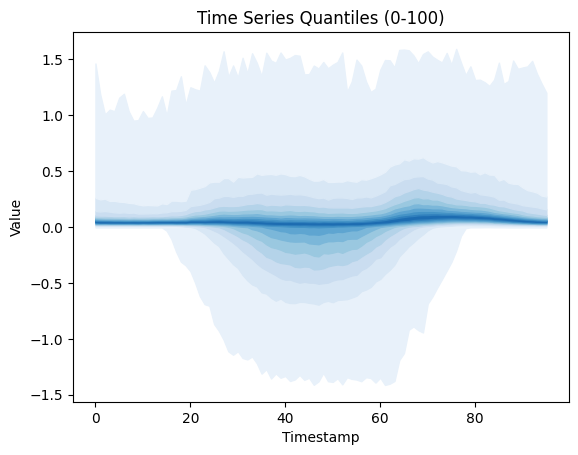

In [33]:
create_quantile_plot(test_series)

### 3.3 Classifier
Create a classifier that trains a model to classify real from fake

In [35]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

generated_data = generated_cnn
combined_data = np.vstack((test_series, generated_data))

# Create labels: 0 for real, 1 for fake
labels = np.zeros((test_series.shape[0] + generated_data.shape[0],))
labels[test_series.shape[0]:] = 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.3, random_state=42)

# Train a logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Train an SVM classifier
clf = SVC()
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

c:\Users\jankr\miniconda3\envs\torch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8500857632933104
              precision    recall  f1-score   support

         0.0       0.92      0.77      0.84      1474
         1.0       0.80      0.93      0.86      1441

    accuracy                           0.85      2915
   macro avg       0.86      0.85      0.85      2915
weighted avg       0.86      0.85      0.85      2915

Accuracy: 0.907032590051458
              precision    recall  f1-score   support

         0.0       0.94      0.87      0.90      1474
         1.0       0.88      0.95      0.91      1441

    accuracy                           0.91      2915
   macro avg       0.91      0.91      0.91      2915
weighted avg       0.91      0.91      0.91      2915

